In [0]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [0]:
# training data
!wget 'https://comp0053-emopain.s3.eu-west-2.amazonaws.com/movementData/train.zip'
!unzip train.zip
# validation data
!wget 'https://comp0053-emopain.s3.eu-west-2.amazonaws.com/movementData/validation.zip'
!unzip validation.zip

## Data description

<img src="https://user-images.githubusercontent.com/23082383/80592520-7c267f00-8a17-11ea-88a9-9706a955d119.png" alt="drawing" width="400"/>

[2] Aung et al. 2016 ‘The Automatic Detection of Chronic Pain-Related Expression: Requirements, Challenges and the Multimodal EmoPain Dataset’ (https://ieeexplore.ieee.org/abstract/document/7173007)

From paper:
- features [1-13]:  postural information described by the
ranges of inner angles in 3D space at 13 angles (see Table 5)
- features [14-26]: velocity based information which
we will refer to as ‘energy’ calculated from the sum square
of the angular velocities at each of the 13 angles
- features [27-30]:  the muscle activity levels using the upper envelope of the rectified signal from each of the four sEMG probes.

From data README:
- feature [31]: exercise type - 1: One-leg-stand, 2: Reach-forward, 3: Bend, 4: Sit-to-stand, 5: Stand-to-sit, 6: Sitting still, 7: Standing still, 8: Walking, 0: Others
- feature [32]: pain level - 0: Healthy, -1: Not reported (only for the patients), 1: Low-level pain, 2: High-level pain
- feature [33]: Protective behavior label – 0: Not protective, 1: Protective

Each file contains the body movement data for a single participant for all exercise sessions under one challenge level (‘normal’ or ‘difficult’)

#### Look at data imbalance of individual files

In [111]:
exclude_files = ['C382N.mat', 'C93D.mat', 'C544D.mat', 'C788N.mat', 'C382D.mat', 'C56D.mat', 'C709N.mat']
all_samples = []
samples = []
for name in os.listdir('./train'):
  sample = loadmat(os.path.join('./train', name))['BD']
  all_samples.append(sample)
  if name not in exclude_files:
    samples.append(sample)
  print('{} - positive: {} total: {} - {:.3}%'.format(name, sum(sample[:, -1]), sample.shape[0], 100*(sum(sample[:, -1])/sample.shape[0])))

P299N.mat - positive: 887.0 total: 13910 - 6.38%
P531N.mat - positive: 1919.0 total: 15757 - 12.2%
P492D.mat - positive: 2068.0 total: 15931 - 13.0%
P921N.mat - positive: 4728.0 total: 19985 - 23.7%
P113N.mat - positive: 1109.0 total: 11605 - 9.56%
P336D.mat - positive: 2930.0 total: 13376 - 21.9%
P699N.mat - positive: 11223.0 total: 24325 - 46.1%
P191N.mat - positive: 3643.0 total: 17458 - 20.9%
P299D.mat - positive: 1215.0 total: 15958 - 7.61%
P699D.mat - positive: 8807.0 total: 23967 - 36.7%
P492N.mat - positive: 341.0 total: 13936 - 2.45%
P890N.mat - positive: 3530.0 total: 14641 - 24.1%
P300D.mat - positive: 7784.0 total: 17985 - 43.3%
P113D.mat - positive: 6588.0 total: 18105 - 36.4%
P191D.mat - positive: 4519.0 total: 15590 - 29.0%
P921D.mat - positive: 5286.0 total: 18051 - 29.3%


#### Load all data

In [85]:
all_data = np.concatenate(all_samples)
print("Positive label: ", sum(all_data[:,-1]))
print("Total :", all_data.shape[0])
print("Imbalance: ", sum(all_data[:,-1]) / all_data.shape[0])

Positive label:  66577.0
Total : 356107
Imbalance:  0.1869578525555521


We can remove the samples that do not have any positive protective behavior label.

In [112]:
data = np.concatenate(samples)
print("Positive label: ", sum(data[:,-1]))
print("Total :", data.shape[0])
print("Imbalance: ", sum(data[:,-1]) / data.shape[0])

Positive label:  66577.0
Total : 270580
Imbalance:  0.24605292334984108


All labels start and end with a protective behaviour label of 0. Truncating the start and end until we get a protective label already reduces data imbalance.

In [0]:
truncated_samples = []
for sample in samples:
  protective_label = sample[:,-1]
  all_indices = np.where(protective_label[:-1] != protective_label[1:])[0]
  padding = 10
  first = all_indices[0] - padding
  last = all_indices[-1] + padding
  truncated_sample = sample[first:last+1, :]
  truncated_samples.append(truncated_sample)

In [160]:
truncated_data = np.concatenate(truncated_samples)
print("Positive label: ", sum(truncated_data[:,-1]))
print("Total :", truncated_data.shape[0])
print("Imbalance: ", sum(truncated_data[:,-1]) / truncated_data.shape[0])

Positive label:  66577.0
Total : 204738
Imbalance:  0.325181451415956


#### When does protective behavior occur?

In [0]:
df = pd.DataFrame(truncated_data, columns=labels)

In [209]:
positive_frames = df[df["Protective behavior label"] == 1]

print("Percentage of positive labels per exercise type")
print(positive_frames["exercise type"].value_counts()/df["exercise type"].value_counts())
print()
print("Percentage of positive labels per pain level")
print(positive_frames["pain level"].value_counts()/df["pain level"].value_counts())

Percentage of positive labels per exercise type
0.0     0.232153
1.0     0.780422
2.0     0.657562
3.0     0.763634
4.0     0.689075
5.0     0.750736
6.0     0.114513
7.0     0.047907
8.0     0.684885
11.0    1.000000
Name: exercise type, dtype: float64

Percentage of positive labels per pain level
-1.0    0.179397
 1.0    0.672298
 2.0    0.801724
Name: pain level, dtype: float64


## Visualize data

#### Look at one file as example

In [0]:
# assuming probe order is simply sequential
labels = ['Angle - Left full body flexion',
          'Angle - Right full body flexion',
          'Angle - Left inner flexion',
          'Angle - Right inner flexion',
          'Angle - Left knee',
          'Angle - Right knee',
          'Angle - Left elbow',
          'Angle - Right elbow',
          'Angle - Left shoulder',
          'Angle - Right shoulder',
          'Angle - Left lateral bend',
          'Angle - Right lateral bend',
          'Angle - neck',
          'Energy - Left full body flexion',
          'Energy - Right full body flexion',
          'Energy - Left inner flexion',
          'Energy - Right inner flexion',
          'Energy - Left knee',
          'Energy - Right knee',
          'Energy - Left elbow',
          'Energy - Right elbow',
          'Energy - Left shoulder',
          'Energy - Right shoulder',
          'Energy - Left lateral bend',
          'Energy - Right lateral bend',
          'Energy - neck',
          'sEMG Probe 1',
          'sEMG Probe 2',
          'sEMG Probe 3',
          'sEMG Probe 4',
          'exercise type',
          'pain level',
          'Protective behavior label'
 ]

In [0]:
df = pd.DataFrame(truncated_samples[7], columns=labels)

In [227]:
df.describe()

,Angle - Left full body flexion,Angle - Right full body flexion,Angle - Left inner flexion,Angle - Right inner flexion,Angle - Left knee,Angle - Right knee,Angle - Left elbow,Angle - Right elbow,Angle - Left shoulder,Angle - Right shoulder,Angle - Left lateral bend,Angle - Right lateral bend,Angle - neck,Energy - Left full body flexion,Energy - Right full body flexion,Energy - Left inner flexion,Energy - Right inner flexion,Energy - Left knee,Energy - Right knee,Energy - Left elbow,Energy - Right elbow,Energy - Left shoulder,Energy - Right shoulder,Energy - Left lateral bend,Energy - Right lateral bend,Energy - neck,sEMG Probe 1,sEMG Probe 2,sEMG Probe 3,sEMG Probe 4,exercise type,pain level,Protective behavior label
count,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,1.331400e+04,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000
mean,0.981019,0.995752,0.846185,0.861412,0.685329,0.651787,1.052110,1.032161,0.942937,0.920626,0.629082,0.672697,1.123986,1.306823e-03,1.042565e-03,1.527743e-03,1.112685e-03,7.369293e-03,5.463140e-03,7.466182e-04,5.687212e-04,6.231275e-05,3.605427e-05,8.765178e-05,1.722480e-04,1.324858e-04,0.037303,0.037540,0.083059,0.184112,3.960042,-0.408067,0.273622
std,0.188446,0.175086,0.290935,0.280840,0.309193,0.295329,0.086836,0.095223,0.033888,0.026375,0.038443,0.056779,0.054536,6.575166e-03,4.573594e-03,7.007904e-03,4.192575e-03,4.364719e-02,3.017840e-02,3.457171e-03,3.185369e-03,4.523924e-04,2.176401e-04,5.612321e-04,1.159588e-03,6.646531e-04,0.049771,0.045040,0.065136,0.117747,3.114442,1.193952,0.445834
min,0.024341,0.040361,0.001530,0.001365,0.000424,0.000084,0.373842,0.326423,0.751885,0.867493,0.519515,0.521268,0.918655,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000008,0.000010,0.000121,0.006744,0.000000,-1.000000,0.000000
25%,0.835191,0.869658,0.652376,0.701776,0.492948,0.475547,1.039765,1.048099,0.929587,0.908415,0.599623,0.627285,1.118004,1.553105e-08,2.038647e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.193303e-08,0.011742,0.013663,0.043001,0.100542,0.000000,-1.000000,0.000000
50%,1.065808,1.079533,1.022857,1.028963,0.867757,0.829310,1.077855,1.066095,0.944731,0.913871,0.632955,0.667411,1.144386,7.812003e-07,2.220885e-07,4.034822e-08,8.759679e-08,4.525572e-07,1.301620e-08,7.029113e-07,5.742584e-07,1.358787e-07,9.564631e-08,2.520382e-07,1.628565e-07,1.354678e-06,0.024959,0.025503,0.066791,0.155980,5.000000,-1.000000,0.000000
75%,1.097930,1.100501,1.027276,1.054145,0.881401,0.850806,1.092991,1.074794,0.951862,0.935579,0.646784,0.712761,1.159078,8.553954e-05,9.448352e-05,5.768834e-05,1.030598e-04,1.154609e-04,1.204939e-04,1.106202e-04,6.891667e-05,9.587993e-06,6.890692e-06,1.280646e-05,1.475022e-05,3.479225e-05,0.044879,0.043749,0.100974,0.238467,7.000000,-1.000000,1.000000
max,1.194737,1.188283,1.106151,1.116679,0.993574,0.926968,1.195991,1.149987,1.064124,1.003947,0.765977,0.932584,1.195582,2.168864e-01,2.042697e-01,2.162341e-01,8.374429e-02,1.335722e+00,1.432248e+00,1.894231e-01,1.832037e-01,2.774850e-02,1.214759e-02,3.487515e-02,6.033263e-02,2.018941e-02,0.963358,0.634325,0.777442,1.333362,8.000000,2.000000,1.000000


#### Plotting feature values over time

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("white")
%matplotlib inline

In [0]:
def plot_dataframe(dataframe, y_label_array):
  # protective_label = df["Protective behavior label"].to_numpy()
  len_df = dataframe.shape[0]
  y_index_changes = np.where(y_label_array[:-1] != y_label_array[1:])[0]
  sns.set(rc={'figure.figsize':(45,20)})
  sns.lineplot(style="coherence", hue="coherence", data=dataframe, dashes=False)

  for i in range(0, len(y_index_changes), 2):
      if y_index_changes[i] < len_df:
          plt.axvspan(y_index_changes[i], y_index_changes[i+1], facecolor='r', alpha=0.3)
  plt.savefig("output.png")

In [0]:
y_label_array = df["Protective behavior label"].to_numpy()

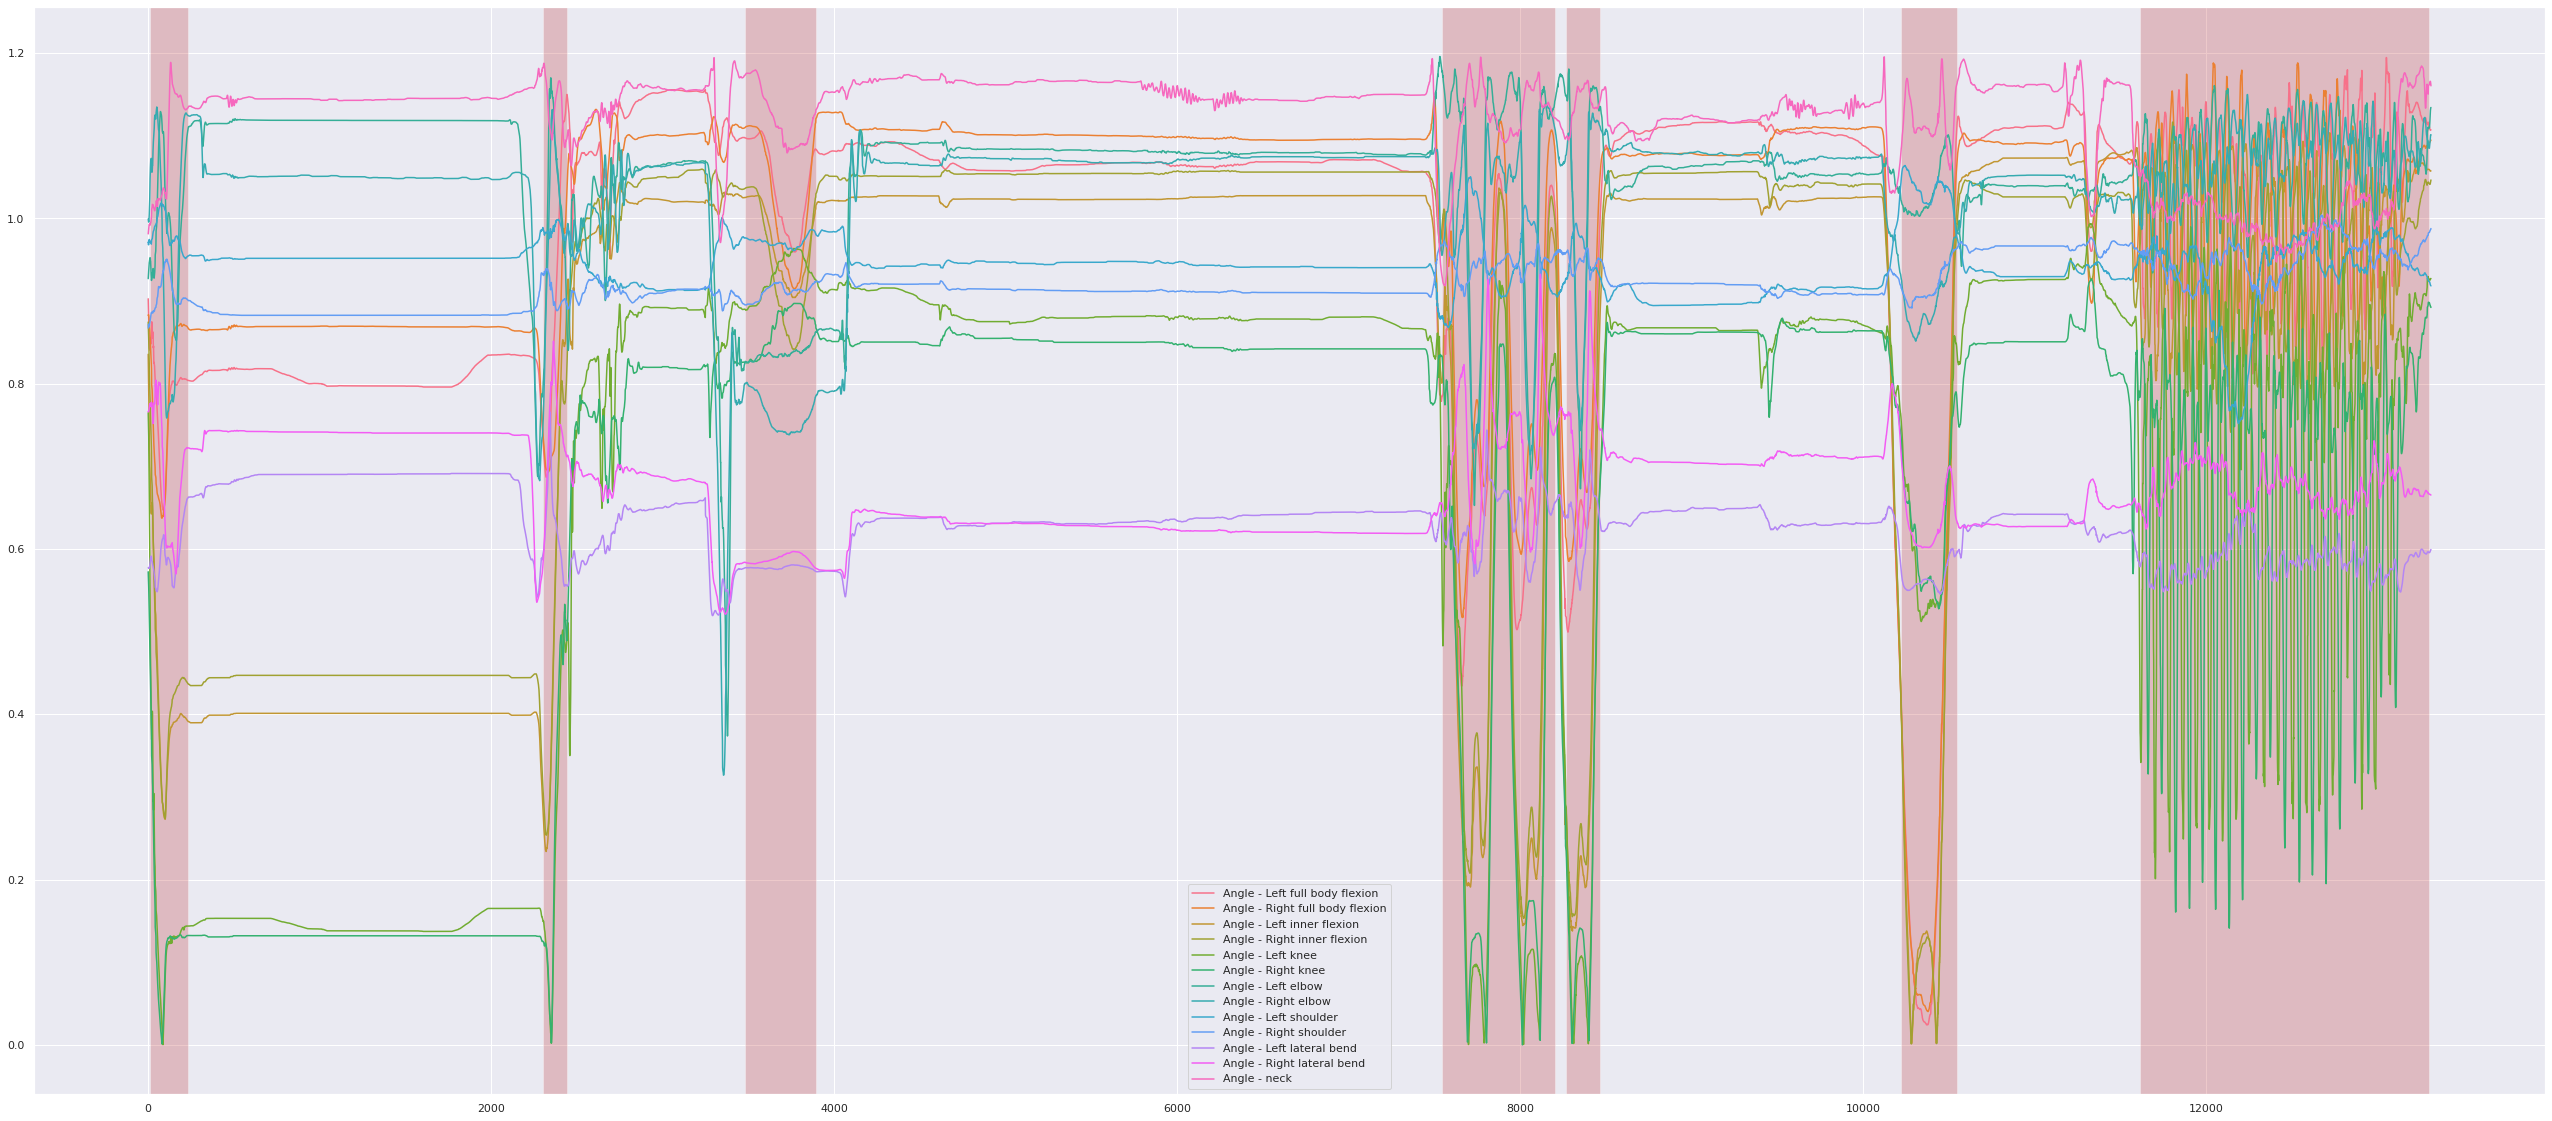

In [231]:
angle_df = df[['Angle - Left full body flexion', 'Angle - Right full body flexion',
       'Angle - Left inner flexion', 'Angle - Right inner flexion',
       'Angle - Left knee', 'Angle - Right knee', 'Angle - Left elbow',
       'Angle - Right elbow', 'Angle - Left shoulder',
       'Angle - Right shoulder', 'Angle - Left lateral bend',
       'Angle - Right lateral bend', 'Angle - neck']]

plot_dataframe(angle_df, y_label_array)

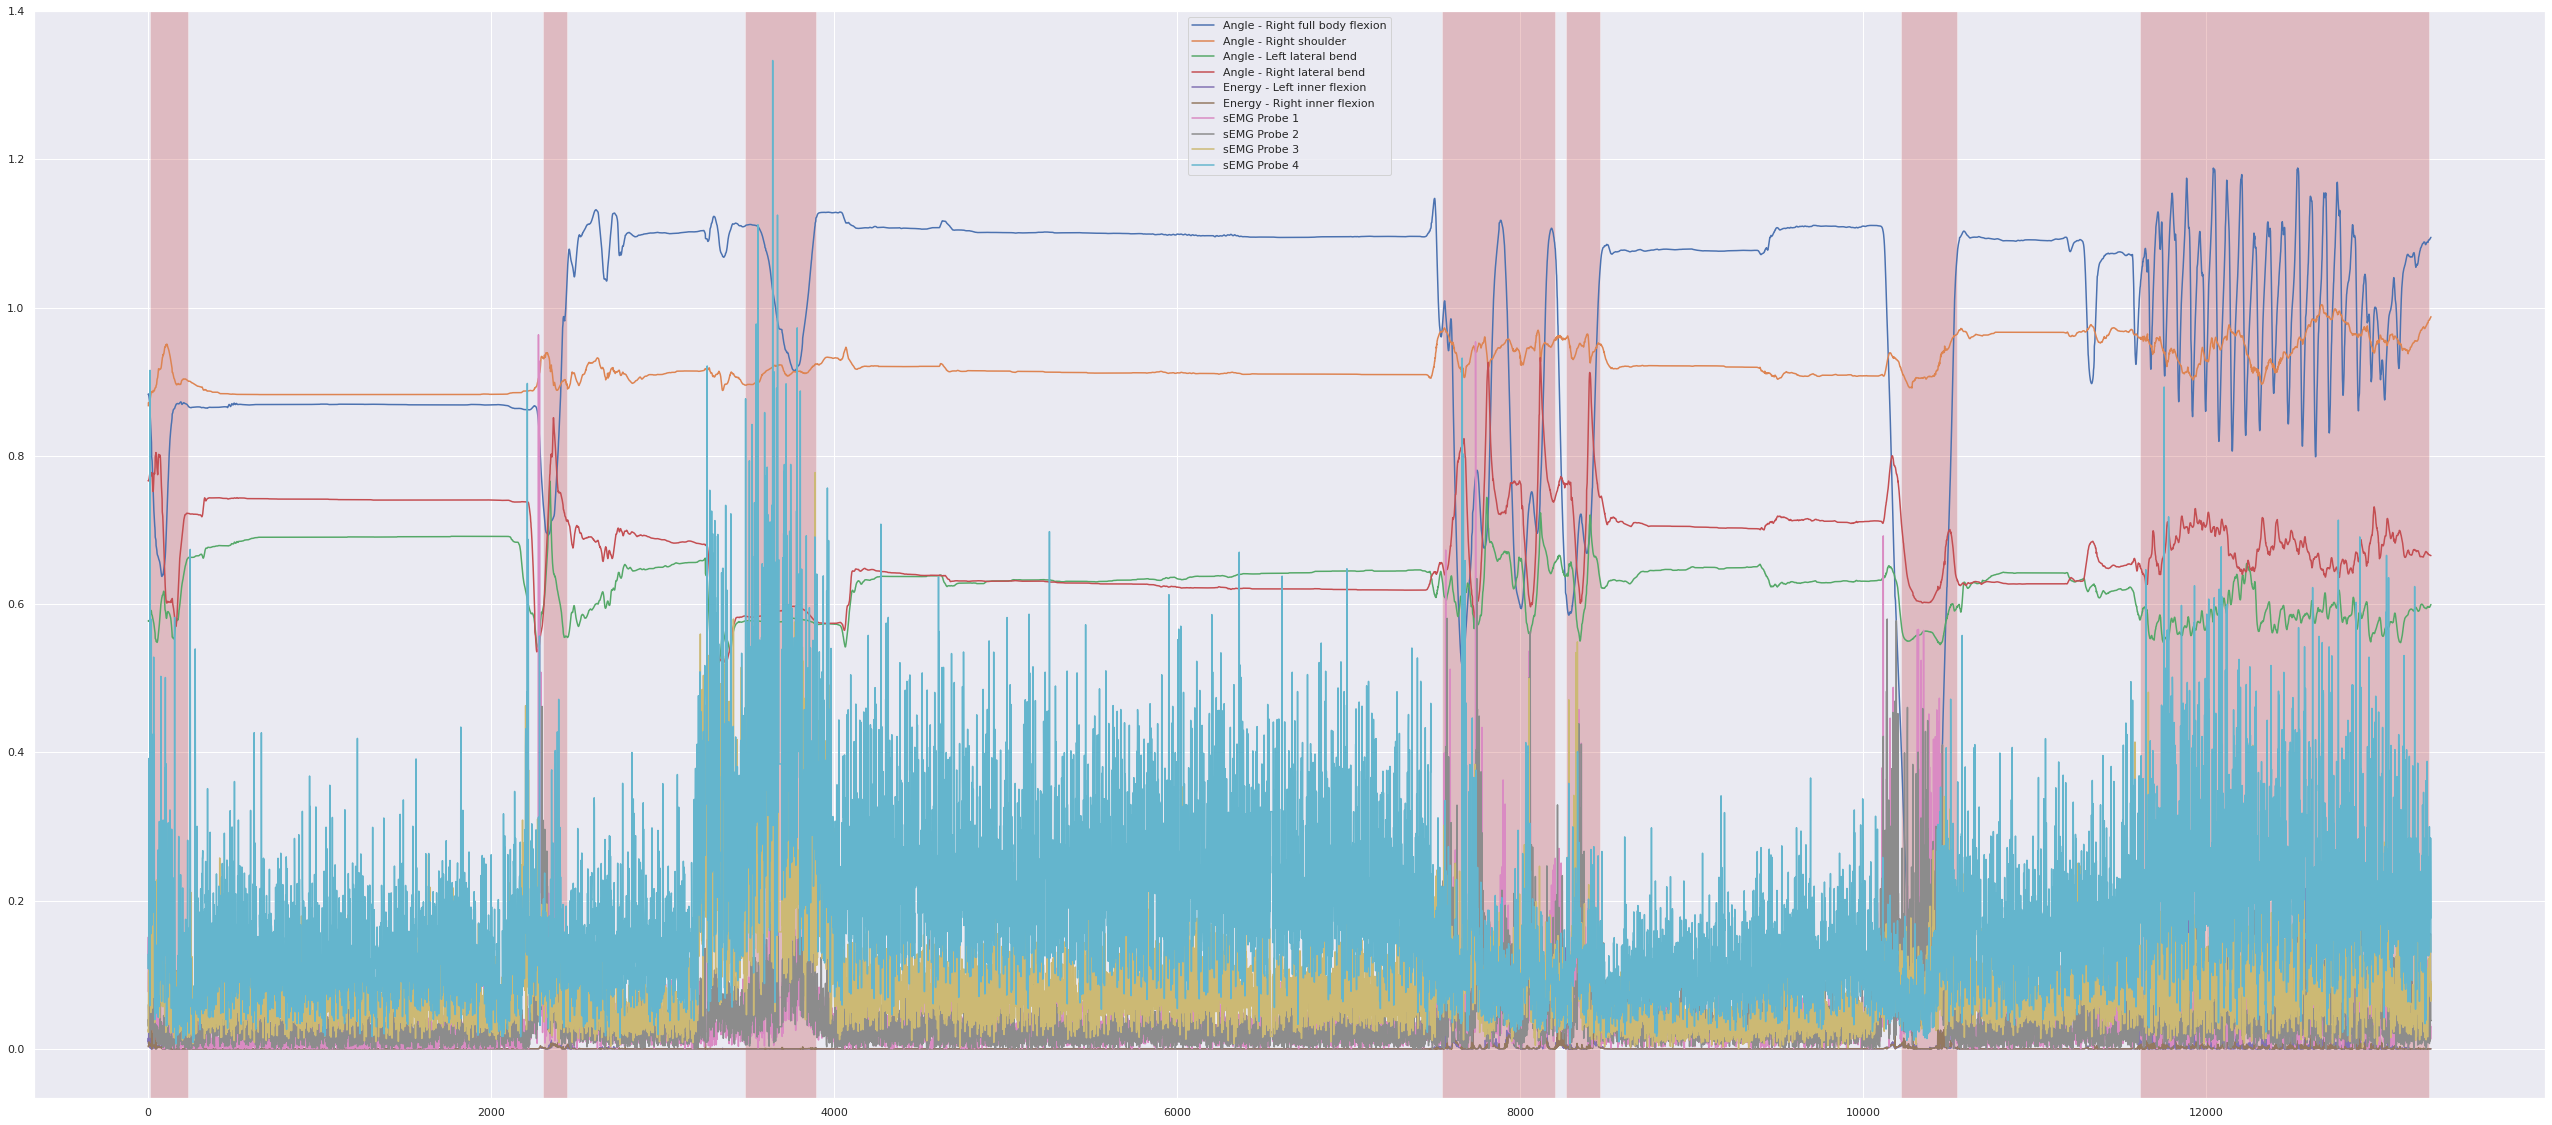

In [232]:
anova_df = df[['Angle - Right full body flexion', 'Angle - Right shoulder', 'Angle - Left lateral bend', 'Angle - Right lateral bend', 'Energy - Left inner flexion', 'Energy - Right inner flexion', 'sEMG Probe 1', 'sEMG Probe 2', 'sEMG Probe 3', 'sEMG Probe 4']]

plot_dataframe(anova_df, y_label_array)

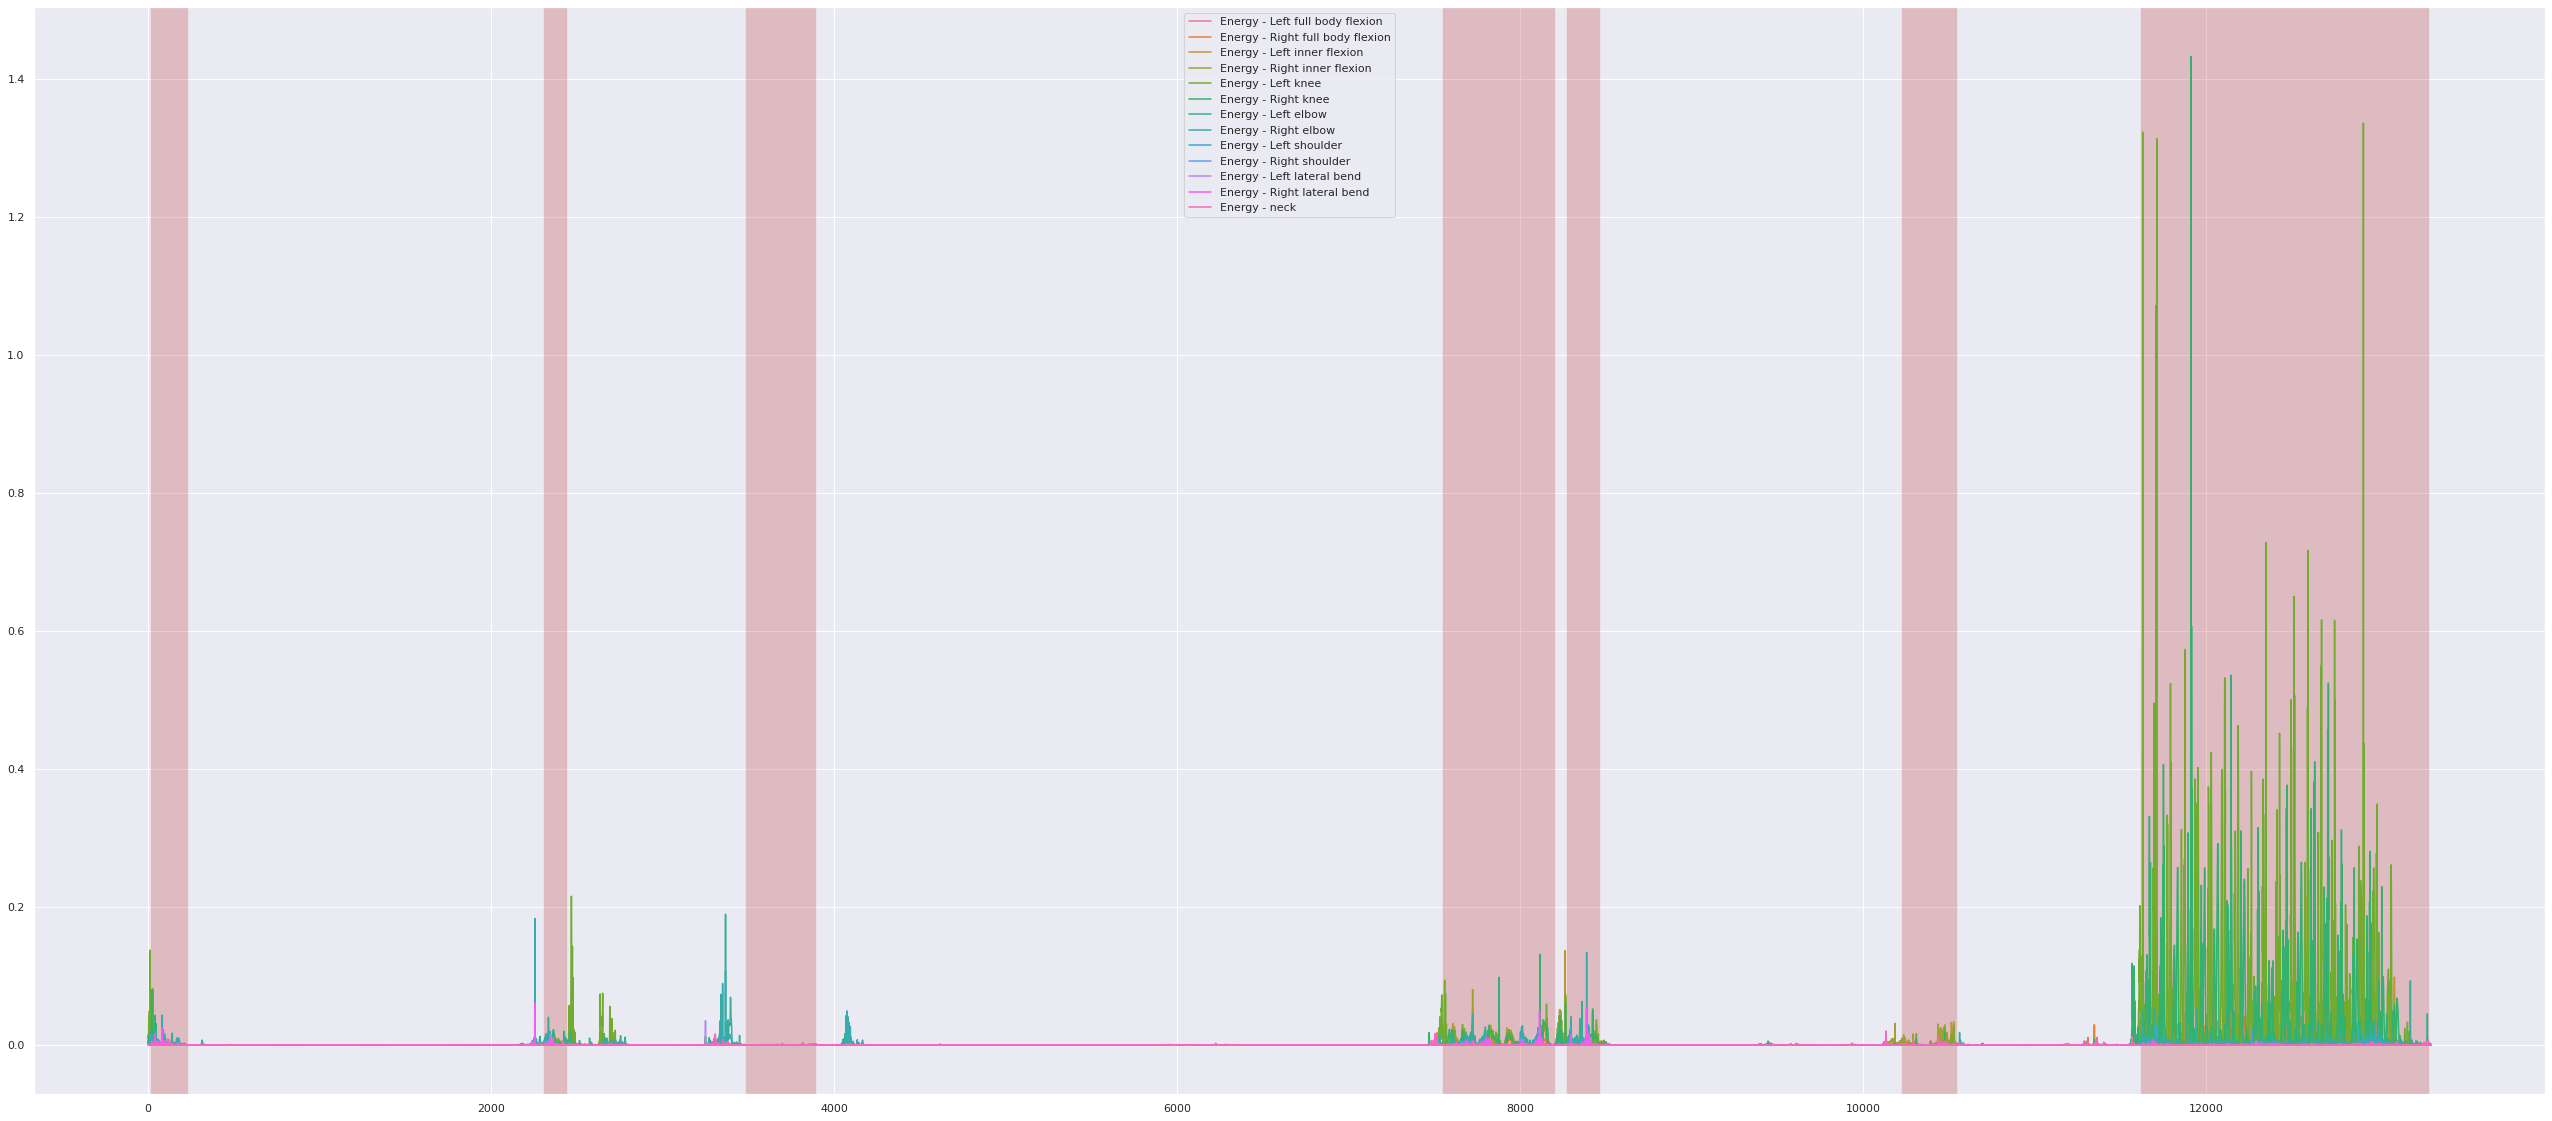

In [233]:
energy_df = df[['Energy - Left full body flexion',
                'Energy - Right full body flexion',
                'Energy - Left inner flexion',
                'Energy - Right inner flexion',
                'Energy - Left knee',
                'Energy - Right knee',
                'Energy - Left elbow',
                'Energy - Right elbow',
                'Energy - Left shoulder',
                'Energy - Right shoulder',
                'Energy - Left lateral bend',
                'Energy - Right lateral bend',
                'Energy - neck']]

plot_dataframe(energy_df, y_label_array)

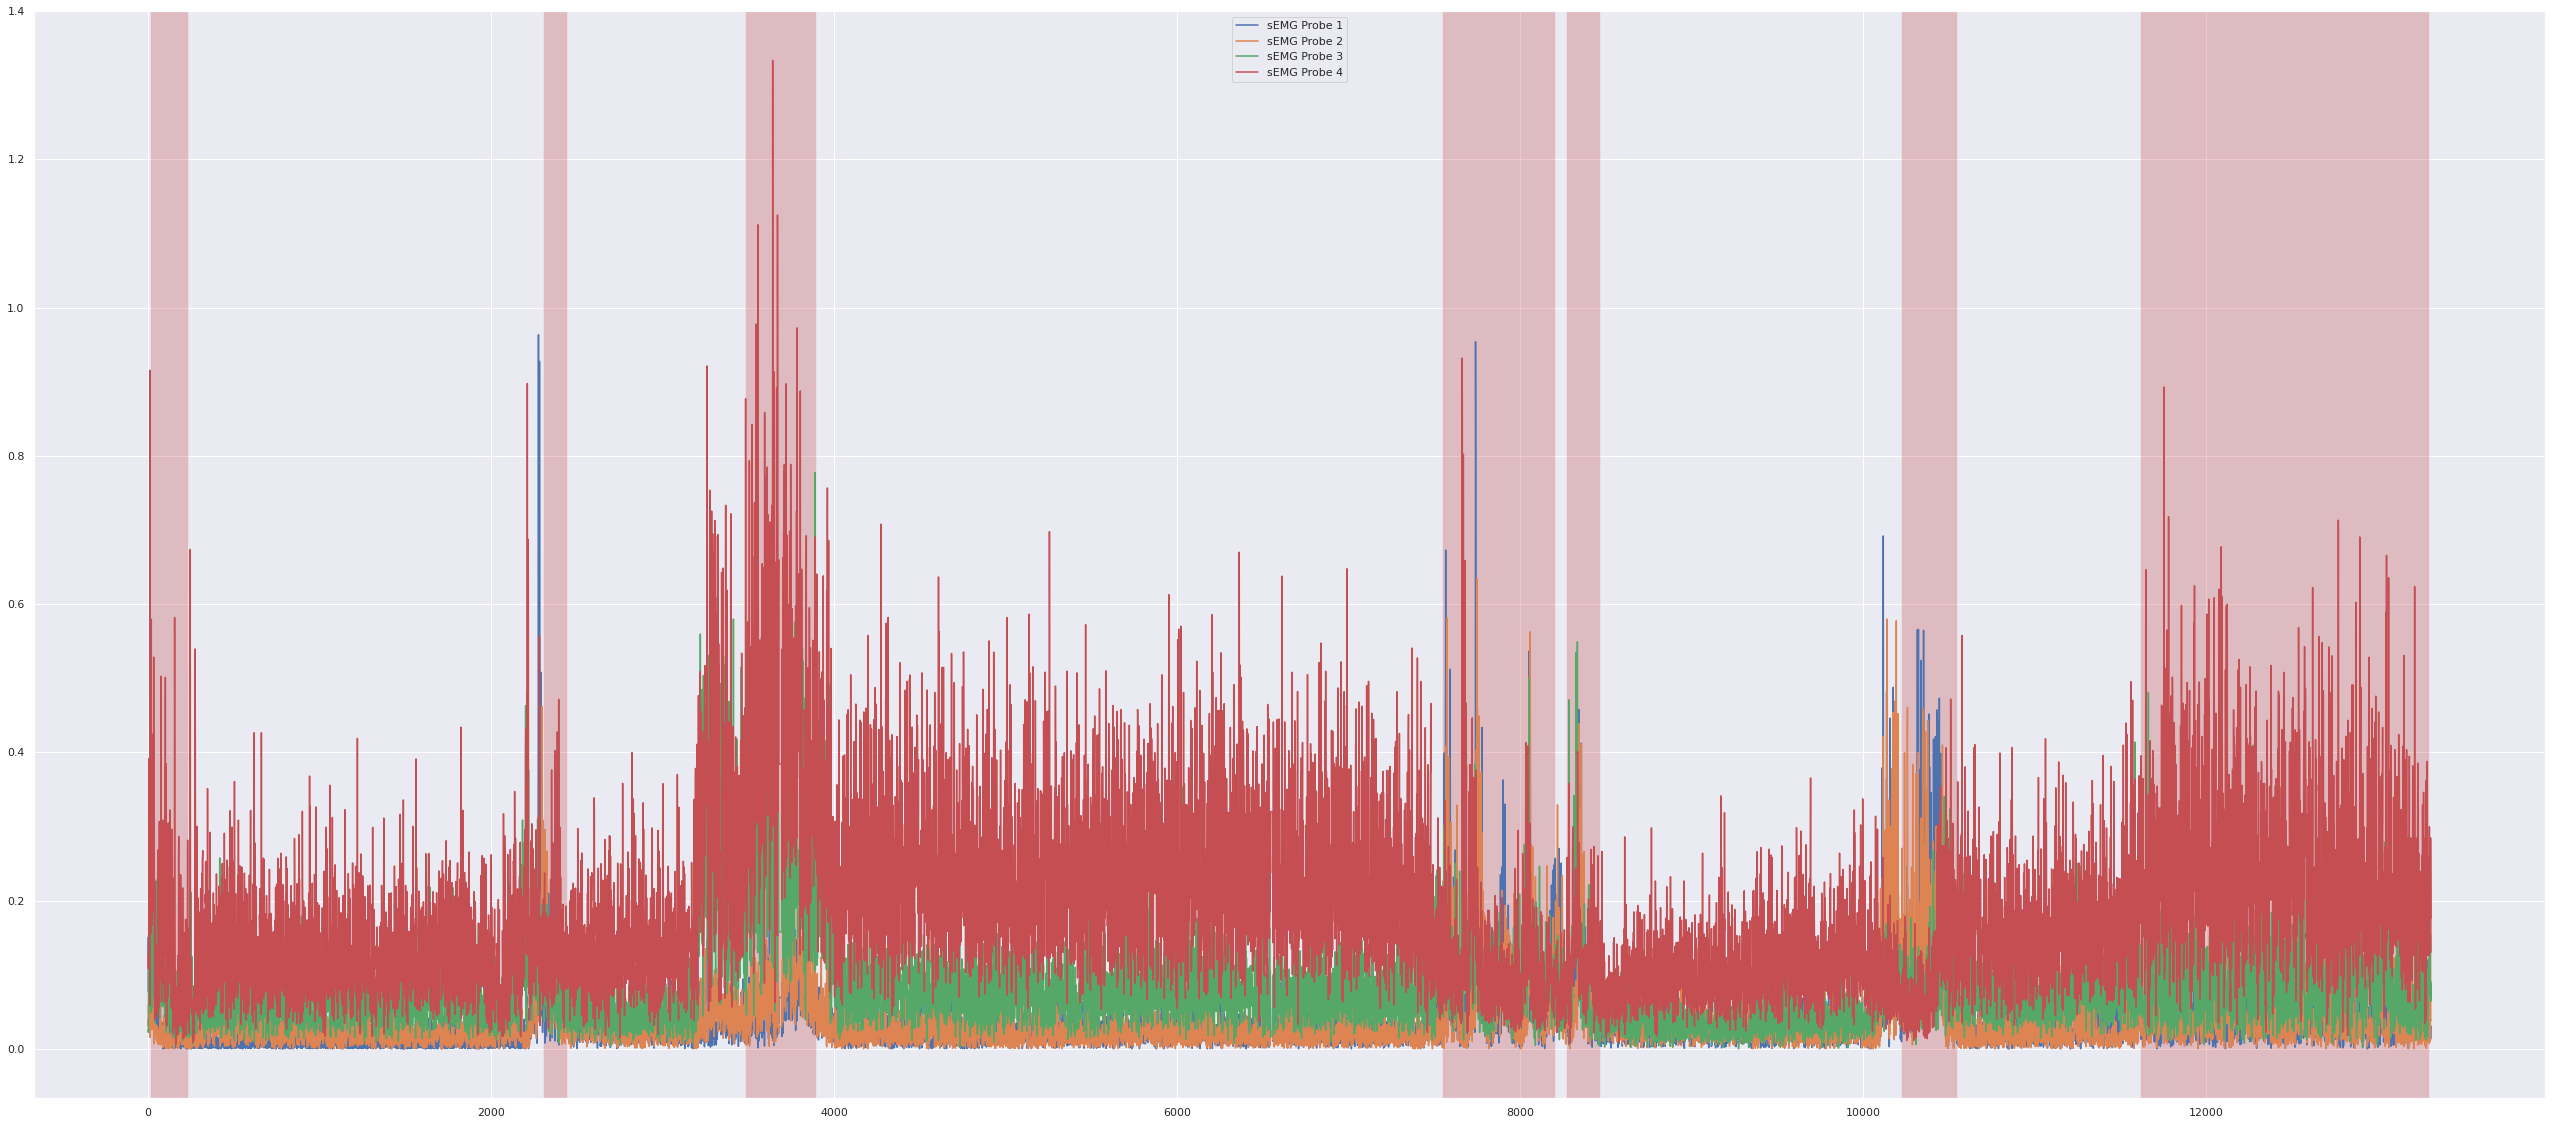

In [234]:
probe_df = df[['sEMG Probe 1',
          'sEMG Probe 2',
          'sEMG Probe 3',
          'sEMG Probe 4']]

plot_dataframe(probe_df, y_label_array)

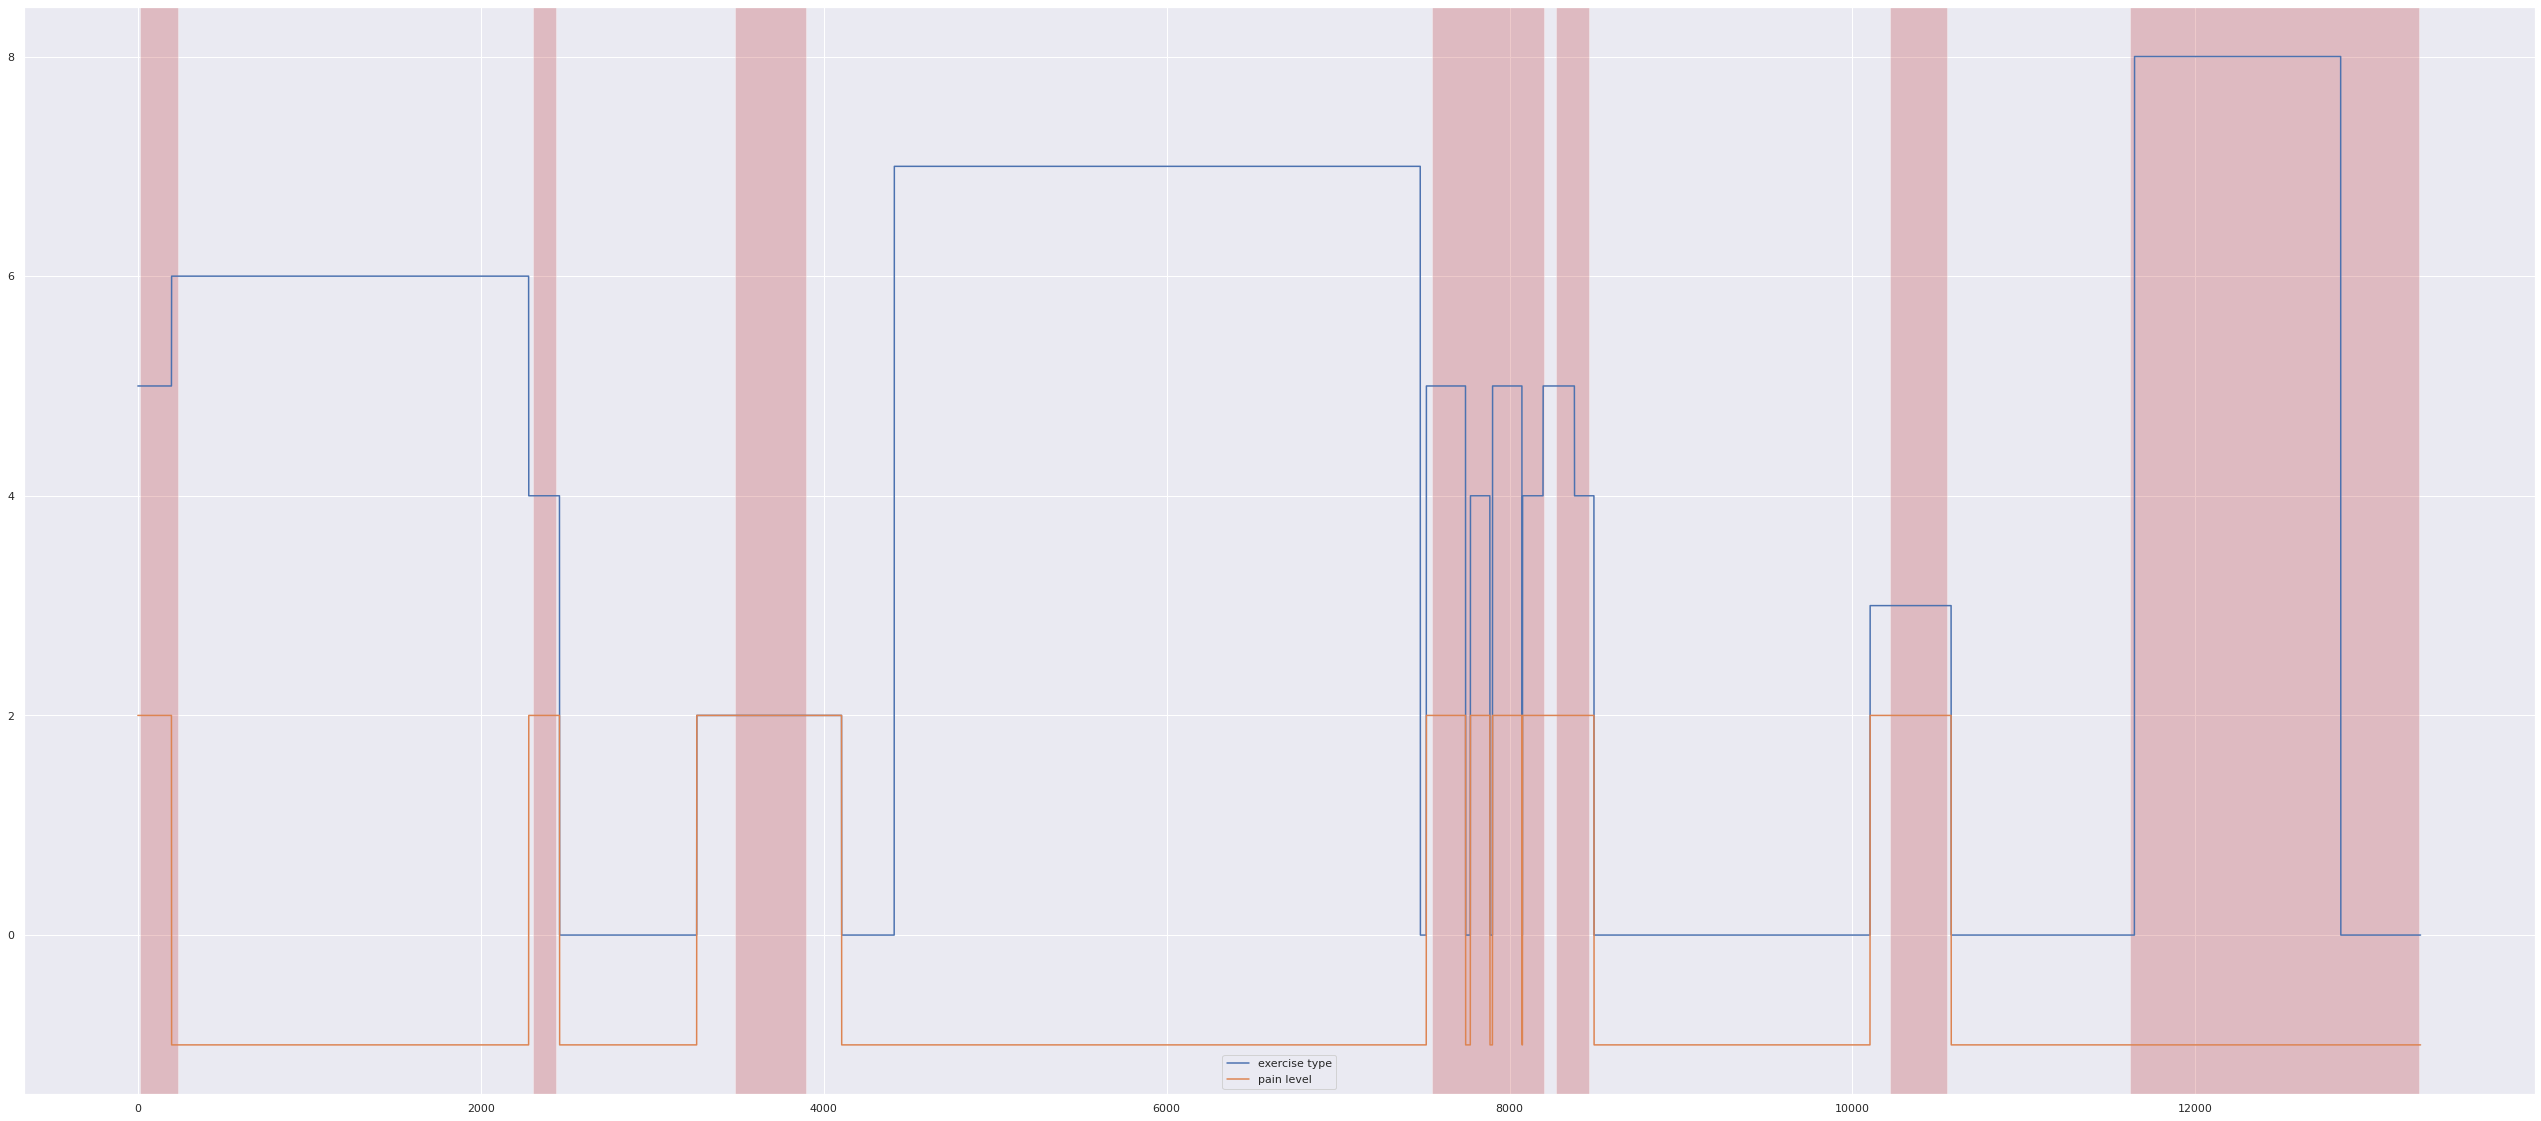

In [235]:
other_df = df[['exercise type','pain level']]

plot_dataframe(other_df, y_label_array)